## Цель иследования
 - выявить частоту (периоды) повторяемости наблюдаемой характеристики 'rang_namber'
 - создать модель для ML позволяющую предиктить периоды на новых данных 
 - предположить факторы влияющие на чатсоту повторяемости
 - https://github.com/julianandrews/flopferret/blob/master/flopferret/board_texture.py

In [1]:
import re
import pandas as pd
from datetime import datetime
import eval7, pprint
from poker.room.pokerstars import PokerStarsHandHistory
from poker.hand import Hand, Combo
import numpy as np
from phevaluator import evaluate_cards
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
# Создали словарь
data_pd = {'TypeOfRoom': [], 'HandId': [], 'Tournament': [], 'Level': [], 'Date': [], 'Hour': [],
           'TimeZoneAbb': [], 'Table': [], 'NoOfPlayers': [], 'bain': [], 'HandHiro': [], 'Board': []}

# Открываем файл
with open('dim1000.txt', 'r') as f: #Poker_\SNG dimetruk 1-54133.txt
    data = f.read()
    
# Ищем нужные данные
result = re.findall('(\w+) Hand #(\d*): Tournament #(\d*),(.*) Level (.*) - (\d{4}/\d+/\d+) (\d+\D\d+\D\d+) (\w*)', data)
Tables = re.findall('Table \'.*\' (.*) Seat .*\n', data)
bains = re.findall('(\D\d+\.\d+\+\D\d+\.\d+)', data)
HandHiros = re.findall("Dealt to dimetruk \D(.. ..)\D", data)
Boards = re.findall("Board \[(.*)\]", data)


# Считаем сколко фишек
s = re.findall('Seat (\d).*chips', data)
s = [int(x) for x in s]
seats = []
length = 1
for i in range(len(s)-1):
    if s[i+1] < s[i]:
        seats.append(length)
        length = 1
    else:
        length += 1
seats.append(length)


# ЗАполнЯем словарь данными
for r, table, bain, seat, handHiro, board in zip(result, Tables, bains, seats, HandHiros, Boards):
    data_pd['TypeOfRoom'].append(r[0])
    data_pd['HandId'].append(r[1])
    data_pd['Tournament'].append(r[2])
    # data_pd['info'].append(r[3])
    data_pd['Level'].append(r[4])
    data_pd['Date'].append(r[5])
    data_pd['Hour'].append(r[6])
    data_pd['TimeZoneAbb'].append(r[7])
    data_pd['Table'].append(table) #table
    data_pd['NoOfPlayers'].append(seat)
    data_pd['bain'].append(bain)
    data_pd['HandHiro'].append(handHiro)
    data_pd['Board'].append(board)

# Создаём ДатаФрейм
d_f = pd.DataFrame(data_pd)
d_f.head()

,TypeOfRoom,HandId,Tournament,Level,Date,Hour,TimeZoneAbb,Table,NoOfPlayers,bain,HandHiro,Board
0,PokerStars,226484810600,3187437334,IV (40/80),2021/05/05,19:56:10,MSK,6-max,2,$13.79+$1.21,Jh Td,8h 8c 7c 3h 6d
1,PokerStars,226484828418,3187437334,V (60/120),2021/05/05,19:56:57,MSK,6-max,2,$13.79+$1.21,Ts 3s,2s 6s As Jc Th
2,PokerStars,226484843891,3187437334,V (60/120),2021/05/05,19:57:39,MSK,6-max,2,$13.79+$1.21,4s 5c,Ks Qh 7h Tc 4c
3,PokerStars,226484859594,3187437334,V (60/120),2021/05/05,19:58:21,MSK,6-max,2,$13.79+$1.21,9c Th,7s 4d Qd
4,PokerStars,226484865470,3187437334,V (60/120),2021/05/05,19:58:37,MSK,6-max,2,$13.79+$1.21,7h 9d,2h Qd 5d Ts 3s


## Преобразуем строковые данные

In [3]:
date = data_pd['Date']
time = data_pd['Hour']

d_f["Date"] = pd.to_datetime(data_pd['Date'])
d_f["Time"] = pd.to_timedelta(data_pd['Hour'])

d_f["DateTime"] = d_f["Date"] + d_f["Time"]
d_f["DateTime"]

d_f.Tournament = d_f.Tournament.astype('int64')
d_f = d_f.astype({'HandId': np.int64, 'Tournament': np.int64})

## Фильтруем данные

In [4]:
# дневной период  https://askdev.ru/q/kak-gruppirovat-i-podschityvat-stroki-po-mesyacam-i-godam-s-pomoschyu-pand-511317/
df_day = d_f['DateTime'].groupby(d_f.DateTime.dt.to_period("D")).agg('count')
df_day

DateTime
2021-05-05     28
2021-05-06    183
2021-05-07     88
2021-05-08    106
2021-05-09    168
2021-05-12     31
2021-05-13      2
2021-05-24     12
2021-05-25     23
2021-05-28     63
2021-05-29     36
2021-05-30     31
2021-06-02      9
2021-07-09     92
2021-07-10     32
2021-07-12     30
2021-07-13      5
2021-07-18     40
2021-08-05     21
Freq: D, Name: DateTime, dtype: int64

In [5]:
df = d_f[['Tournament', 'HandId','Date', 'HandHiro', 'Board']]
df.head()

,Tournament,HandId,Date,HandHiro,Board
0,3187437334,226484810600,2021-05-05,Jh Td,8h 8c 7c 3h 6d
1,3187437334,226484828418,2021-05-05,Ts 3s,2s 6s As Jc Th
2,3187437334,226484843891,2021-05-05,4s 5c,Ks Qh 7h Tc 4c
3,3187437334,226484859594,2021-05-05,9c Th,7s 4d Qd
4,3187437334,226484865470,2021-05-05,7h 9d,2h Qd 5d Ts 3s


In [6]:
#  Используйте group by и lambda для имитации фильтра для value_counts()  
# https://softhints.com/pandas-how-to-filter-results-of-value_counts/
# df = data_filter.groupby('Tournament').filter(lambda x: len(x) > 100) #(data_filter['Tournament'].value_counts().mean())*2)


In [7]:
df.Tournament.value_counts().head()

3188224941    76
3227159788    65
3190325009    54
3188077995    48
3188088059    45
Name: Tournament, dtype: int64

In [8]:
# Prepare Data
# df_plot = df.groupby('Tournament').size()

# # Make the plot with pandas
# df_plot.plot(kind='pie', subplots=True,autopct="%.2f", figsize=(8, 8))
# plt.title("Колличество комбинаций/день")
# plt.ylabel("")
# plt.show()

In [9]:
# объеденяем руку и борд, выводим название комбинации

df.loc[:,['hand']] = df['HandHiro'] + " " + df['Board']
# hand = df['hand'].values[7].split()
# print(hand)

hand_ev = [eval7.Card(s) for s in (df['hand'].values[7].split())]
rang = eval7.evaluate(hand_ev)   # ранг комбинации
# print(rang)

eval7s = eval7.handtype(rang)  #  название комбинации

df['rang'] = eval7.evaluate(hand_ev)
df['eval7s'] =  eval7.handtype(rang)

C:\Users\artio\AppData\Local\Temp\ipykernel_22612\946703193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,['hand']] = df['HandHiro'] + " " + df['Board']
C:\Users\artio\AppData\Local\Temp\ipykernel_22612\946703193.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rang'] = eval7.evaluate(hand_ev)
C:\Users\artio\AppData\Local\Temp\ipykernel_22612\946703193.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [10]:
df[['HandId', 'Date','hand', 'rang', 'eval7s']].head()  # применим фильтер по столбцам

,HandId,Date,hand,rang,eval7s
0,226484810600,2021-05-05,Jh Td 8h 8c 7c 3h 6d,17392128,Pair
1,226484828418,2021-05-05,Ts 3s 2s 6s As Jc Th,17392128,Pair
2,226484843891,2021-05-05,4s 5c Ks Qh 7h Tc 4c,17392128,Pair
3,226484859594,2021-05-05,9c Th 7s 4d Qd,17392128,Pair
4,226484865470,2021-05-05,7h 9d 2h Qd 5d Ts 3s,17392128,Pair


In [11]:
# def new_type(row):
#     if row.traffic_source.lower() in ('yandex', 'google'):
#         return 'organic'
#     elif row.traffic_source.lower() in ('paid', 'email'):
#         if row.region.lower() == 'russia':
#             return 'ad'
#         else:
#             return 'other'

In [12]:
# log['source_type'] = log.apply(new_type, axis = 1)
# log.head(12)

In [13]:
# log.loc[log.traffic_source.isin(['yandex', 'google']), 'traffic_type'] = 'organic' 

In [14]:
df['hand_rang'] = df['HandHiro'] + " " + df['Board']
df['hand_rang'].head()

C:\Users\artio\AppData\Local\Temp\ipykernel_22612\4235121756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hand_rang'] = df['HandHiro'] + " " + df['Board']


0    Jh Td 8h 8c 7c 3h 6d
1    Ts 3s 2s 6s As Jc Th
2    4s 5c Ks Qh 7h Tc 4c
3          9c Th 7s 4d Qd
4    7h 9d 2h Qd 5d Ts 3s
Name: hand_rang, dtype: object

In [15]:
print(type(df['hand_rang']), type(df['hand_rang'].values[7].split()))
df['hand_rang'].values[0].split()

<class 'pandas.core.series.Series'> <class 'list'>


['Jh', 'Td', '8h', '8c', '7c', '3h', '6d']

In [16]:
# df['hand_rang'].to_list()
# df['hand_rang'].tolist()
# np.array(df['hand_rang'].tolist())
# Ls = list(df['hand_rang'])
ls = df['hand_rang'].str.split()
ls

0      [Jh, Td, 8h, 8c, 7c, 3h, 6d]
1      [Ts, 3s, 2s, 6s, As, Jc, Th]
2      [4s, 5c, Ks, Qh, 7h, Tc, 4c]
3              [9c, Th, 7s, 4d, Qd]
4      [7h, 9d, 2h, Qd, 5d, Ts, 3s]
                   ...             
995        [5s, 6s, 3d, 7d, 2s, 2h]
996    [8d, 9c, 5s, Th, 4c, 7s, Js]
997            [Td, 6h, 9c, Kc, Jc]
998    [Ts, Kh, 4c, 9h, 7c, 5d, 8s]
999    [Tc, Th, Qd, 2d, Ah, 6d, 3d]
Name: hand_rang, Length: 1000, dtype: object

In [17]:
# напишем функцию получения ранг комбинации

def evaluate_(hand):
    """
    На вход получает карты, на выход 
    число ранг по eval7
    """
    hand_ev = [eval7.Card(s) for s in (hand)]
    return eval7.evaluate(hand_ev)

a = ('Jh', 'Td', '8h', '8c', '7c', '3h', '6d')
evaluate_(a)

17209424

In [18]:
# напишем функцию получения названия ранга

def handtype_(rang):
    """
    На вход получает ранг, на выход 
    название 
    """
    return eval7.handtype(rang)

handtype_(17209424)

'Pair'

In [85]:
# Применим функцию к столбцу hand  и запишем в новый столбец rang_namber

df['rang_namber'] = df['hand_rang'].str.split().apply(evaluate_)
df['handtypes'] = df['rang_namber'].apply(handtype_)
df[['Date','rang_namber', 'handtypes','HandId']]
# df['filter'] = df.loc[df.handtypes.str.contains('Two Pair', 'Trips', 'Straight', 'Full House', 'Quads', 'Straight Flush'), 'rang_namber']

C:\Users\artio\AppData\Local\Temp\ipykernel_32736\2031913485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rang_namber'] = df['hand_rang'].str.split().apply(evaluate_)
C:\Users\artio\AppData\Local\Temp\ipykernel_32736\2031913485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['handtypes'] = df['rang_namber'].apply(handtype_)


,Date,rang_namber,handtypes,HandId
0,2021-05-05,17209424,Pair,226484810600
1,2021-05-05,84706320,Flush,226484828418
2,2021-05-05,16956032,Pair,226484843891
3,2021-05-05,690002,High Card,226484859594
4,2021-05-05,690003,High Card,226484865470
...,...,...,...,...
995,2021-08-05,16798768,Pair,228816365202
996,2021-08-05,67698688,Straight,228816445233
997,2021-08-05,759924,High Card,228816502665
998,2021-08-05,755557,High Card,228816568248


In [86]:
df_raw = df.groupby([df.Date.dt.to_period("M"),"handtypes"])['rang_namber'].count()
df_raw

Date     handtypes 
2021-05  Flush          16
         Full House     21
         High Card     232
         Pair          328
         Straight       24
         Trips          23
         Two Pair      127
2021-06  Flush           1
         High Card       3
         Pair            5
2021-07  Flush           1
         Full House      4
         High Card      64
         Pair           90
         Quads           1
         Straight        6
         Trips           6
         Two Pair       27
2021-08  Full House      1
         High Card       6
         Pair           10
         Straight        1
         Trips           1
         Two Pair        2
Name: rang_namber, dtype: int64

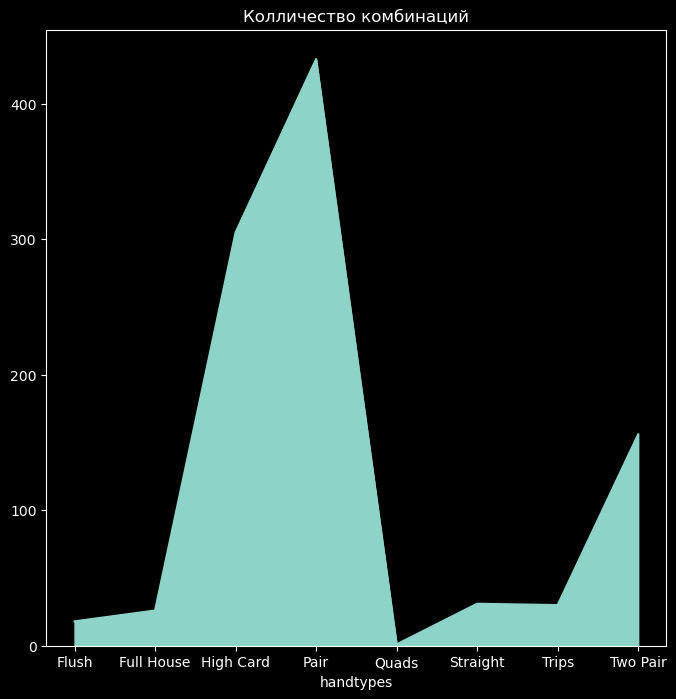

In [87]:
# Prepare Data
df_plot = df.groupby('handtypes').size()

# Make the plot with pandas
df_plot.plot(kind='area', subplots=True, figsize=(8, 8))
plt.title("Колличество комбинаций")
plt.ylabel("")
plt.show()

In [88]:
# df['DateTime'] = df['DateTime'][(df['DateTime'] > '2018-10-01 20:00:00') & (df['DateTime'] < '2018-10-02 00:00:00')]
# df['DateTime']


In [90]:
# отфильтруем комбинации "старшая карта" и "пара"
df['filter'] = df.loc[:,['rang_namber']][df.loc[:,['rang_namber']] > 50000000] #[((df['rang_namber'] > 50000000) & (df['rang_namber'] < 60000000))]
df = df.dropna()
df[['Date','filter','handtypes','HandHiro','Board']].head()
# df['filter_Two Pair'] = df['handtypes'][df['handtypes'] == 'Two Pair']
# df['filter_Two Pair']

,Date,filter,handtypes,HandHiro,Board
1,2021-05-05,84706320,Flush,Ts 3s,2s 6s As Jc Th
8,2021-05-05,50968576,Trips,8d Jh,Kc 7h Js Td Jc
16,2021-05-05,84715347,Flush,Kh 7c,9d 5d Ad Qd 7d
27,2021-05-05,84715824,Flush,Ad 2d,9h 5d Qh Jd Qd
29,2021-05-06,67895296,Straight,Qd Ah,Ts Kh Jc 8c 7d


In [65]:
data = df[['DateTime', 'filter']]
data.head()

KeyError: "['DateTime'] not in index"

In [76]:
data.isnull().sum()

DateTime    0
filter      0
dtype: int64

In [77]:
# преобразуем время во временной ряд


In [78]:


idx = df['DateTime']
 # datetime.timedelta(seconds=24*60*60).total_seconds()

# second = df['DateTime'].dt.total_seconds()
# second

# idx = pd.date_range(df['DateTime'], periods=5, freq="H")
# idx
tim = pd.Series(range(len(idx)), index=idx)

# ts.resample("2H").mean()
tim 

DateTime
2018-08-07 22:22:20      0
2018-08-07 22:30:28      1
2018-08-07 22:31:51      2
2018-08-07 22:50:10      3
2018-08-07 23:09:42      4
                      ... 
2018-10-31 14:43:01    577
2018-10-31 14:50:16    578
2018-10-31 15:00:30    579
2018-10-31 15:04:40    580
2018-10-31 15:06:12    581
Length: 582, dtype: int64

In [79]:
# # # idx = pd.date_range('2019-01-01', periods=48, freq='H')
# # x = pd.Series(range(len(idx)), index=idx)
# y = tim
# # add 'hour' and 'day' columns in the dataframe
# d = {'x': x, 'y': y, 'hour': idx.hour, 'day': idx.day}
# df = pd.DataFrame(data=d)
# # use 'hour' as x axis to plot, and 'day' as marker color
# df.plot.scatter(x='hour', y='y', c='day', colormap='rainbow')
# plt.show()

In [80]:
data.dtypes

DateTime    datetime64[ns]
filter             float64
dtype: object

In [81]:
# установить datetime Объект в качестве индекса кадра данных
data = data.set_index('DateTime')
data.head(20)

,filter
DateTime,
2018-08-07 22:22:20,50701824.0
2018-08-07 22:30:28,101462016.0
2018-08-07 22:31:51,67895296.0
2018-08-07 22:50:10,101130240.0
2018-08-07 23:09:42,50492672.0
2018-08-07 23:13:22,67502080.0
2018-08-07 23:15:44,50973184.0
2018-08-07 23:19:35,101122048.0
2018-08-07 23:19:54,67567616.0


<AxesSubplot:xlabel='DateTime'>

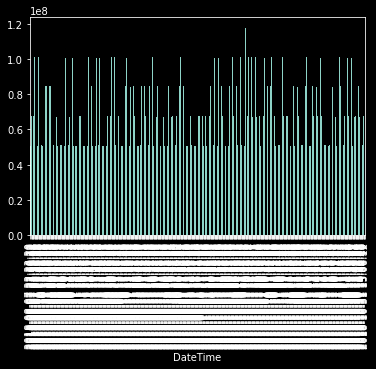

In [82]:

# data.plot(grid=True)

data['filter'].plot(kind='bar')

# import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
# # Группировка за месяц
# df_month = data.resample("M").mean()

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
# ax.bar(
#     df_month['2018':].index, 
#     df_month.loc['2016':, "filter"], 
#     width=25, align='center')

In [85]:
from pandas import Series
from matplotlib import pyplot
series = df
series.plot(style='k.')
pyplot.show()


OverflowError: int too big to convert

<Figure size 432x288 with 1 Axes>